In [2]:
# Import libraries. 
# Generate images in the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import gzip
import itertools
import numpy as np
import os
import time
import pandas as pd
import seaborn as sns

import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file

# Import colour palettes for later on
from bokeh.palettes import Category20b
from bokeh.palettes import Purples
from bokeh.palettes import Greens
from bokeh.palettes import YlOrBr
from bokeh.palettes import YlOrRd
from bokeh.palettes import PuOr
from bokeh.palettes import RdGy

# Dimension reduction tools
from sklearn.decomposition import PCA as PCA
from sklearn.manifold import TSNE
import umap 

/Users/gozdecilingir/mambaforge/envs/beyond/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/gozdecilingir/mambaforge/envs/beyond/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/gozdecilingir/mambaforge/envs/beyond/lib/pyth

In [3]:
#load population data
population_names = pd.read_csv('oryx_pop_info_sorted_46_final.txt', sep='\t', header=0)

In [4]:
#Generating the pandas dataframe called Data_Struct
Data_Struct=population_names

KeyboardInterrupt: 

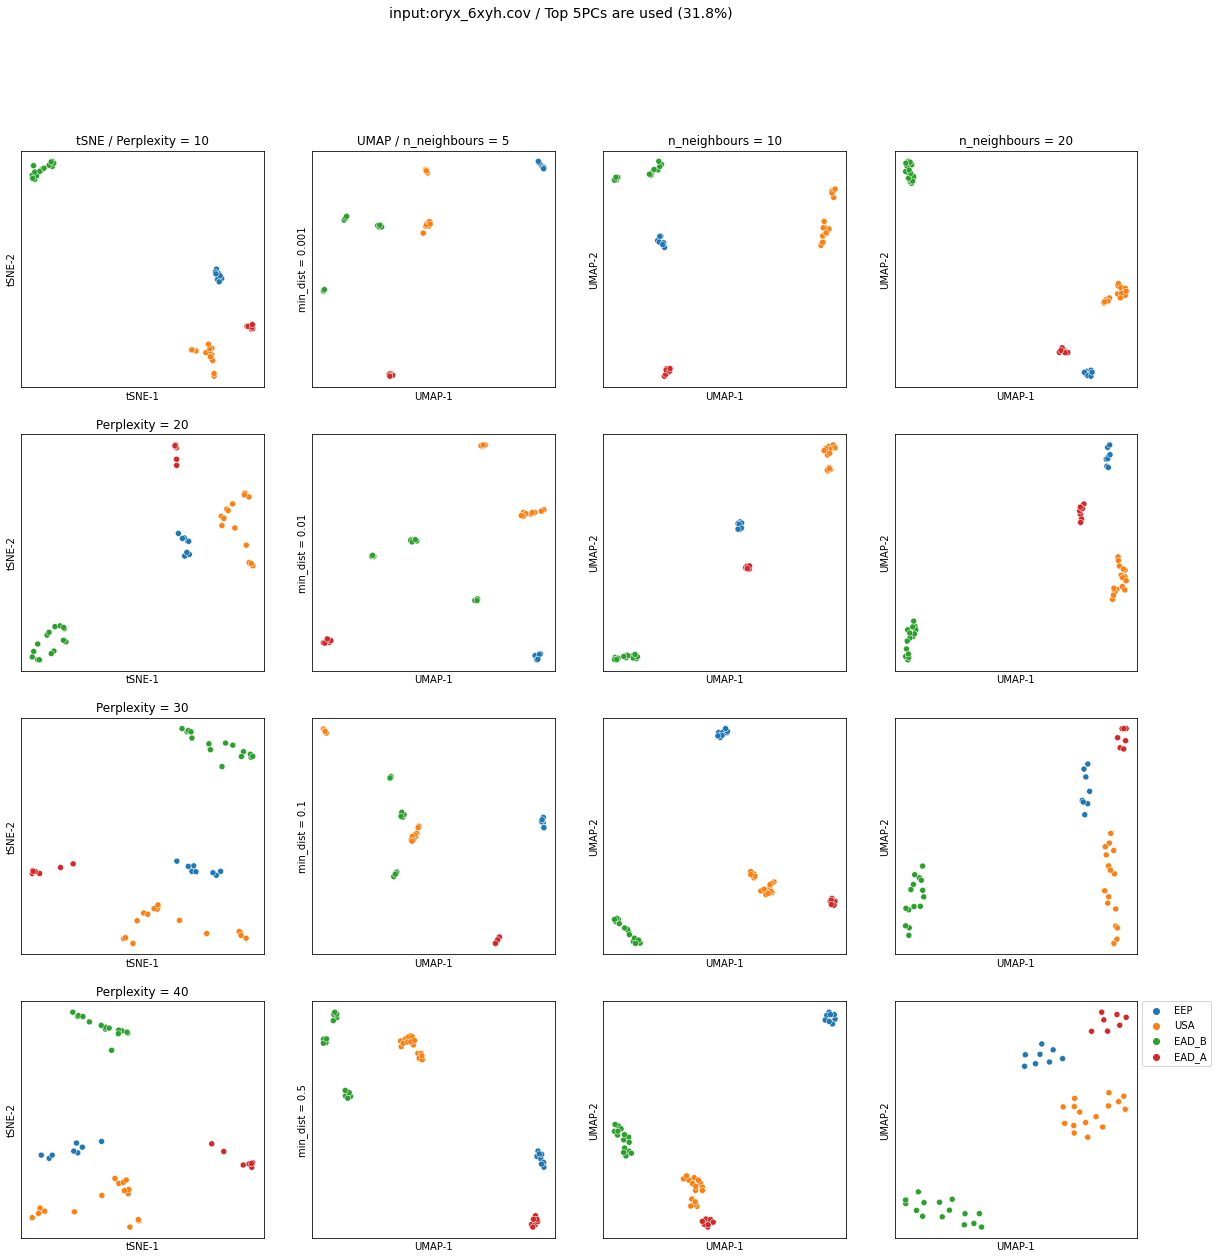

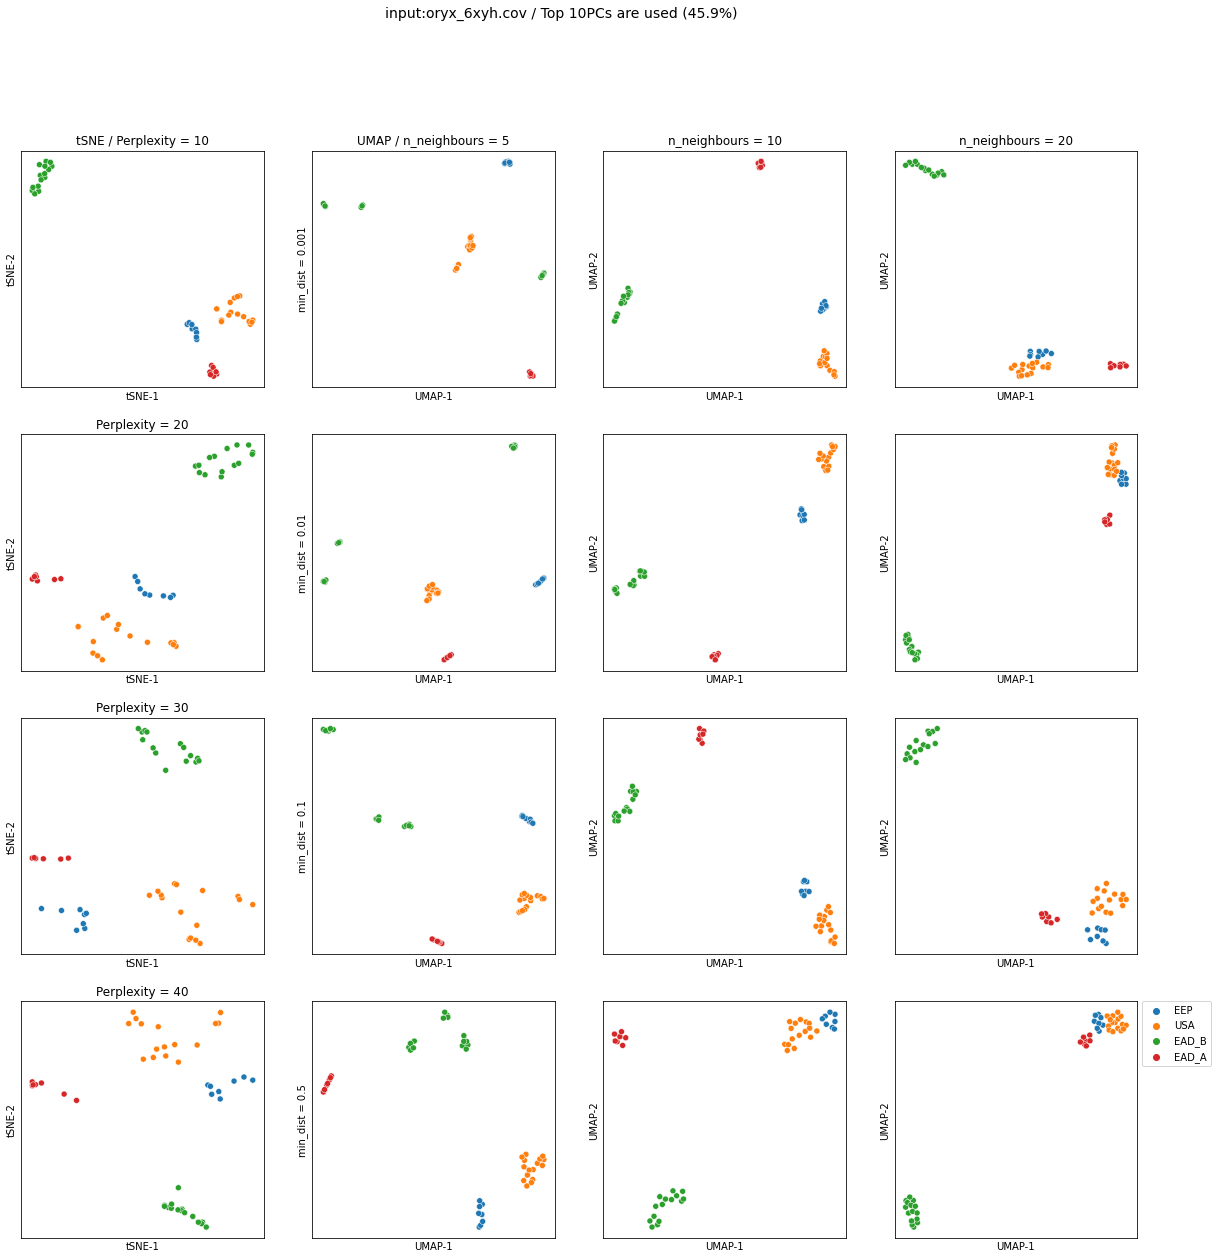

In [5]:
#load the covariance matrices
#this list contains all covariance matrices as an exhaustive list
#it will be used to loop through
file_list=('oryx_6xyh.cov','oryx_2xyh.cov','oryx_0.5xyh.cov')
#file_list=('eep_usa_2x.cov','eep_usa_0.5x.cov')

for filename in file_list:
    cov_mat= pd.read_csv(filename, sep=' ', header=None)
    cov_mat_np=cov_mat.to_numpy()

    # calculate eigen vectors and eigen values from the initial covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eig(cov_mat_np)

    # sorting them from largest to smallest
    idx = eigen_vals.argsort()[::-1]   
    eigenValues = eigen_vals[idx]
    eigenVectors = eigen_vecs[:,idx]
    scaled_eigenvectors = eigenVectors * eigenValues
    
    pca_data_array = np.array(scaled_eigenvectors).astype(float)

    # calculating the total explained variance
    expl_pre=eigenValues/sum(eigenValues)
    expl=np.cumsum(expl_pre)

    expl_df=pd.DataFrame(expl_pre*100,columns=['explained_variance'])
    expl_df['cumulative_expl']=expl*100
    expl_df.set_index(np.arange(1, eigenVectors.shape[0] + 1), inplace=True)


    Data_Struct['EigenVect1']=pca_data_array[:,0]
    Data_Struct['EigenVect2']=pca_data_array[:,1] 

    # Number of principal components to use in a for loop
    number_of_PCs_list=(5,10,20,40)
    
    for n_pc in number_of_PCs_list:
        # Project the wPCA(eigenvectors*eigenvalues) via t-SNE to 2 dimensions.
        perplexity_values=(10,20,30,40)
        for perp in perplexity_values:
            np.random.seed(111)
            proj_tsne = TSNE(n_components=2,perplexity=perp).fit_transform(pca_data_array[:,:n_pc])
            Data_Struct['tSNE-1 perp'+str(perp)]=proj_tsne[:,0]
            Data_Struct['tSNE-2 perp'+str(perp)]=proj_tsne[:,1]
        
        
        
        # Project the wPCA(eigenvectors*eigenvalues) via UMAPto 2 dimensions.        
        n_neighbors_nums=(5,10,20)
        mindists=(0.001,0.01,0.1,0.5)
        
        for nn in n_neighbors_nums:
            for mind in mindists:
                np.random.seed(111)
                proj_umap = umap.UMAP(n_components=2, n_neighbors=nn, min_dist=mind).fit_transform(pca_data_array[:,:n_pc])
                Data_Struct['UMAP-1 numn'+str(nn)+' mindist'+str(mind)]=proj_umap[:,0]
                Data_Struct['UMAP-2 numn'+str(nn)+' mindist'+str(mind)]=proj_umap[:,1]

        # plotting part
        fig, axs = plt.subplots(4, 4,figsize=(20, 20))

        #axs[1,1] = Data_Struct.plot.scatter(x='X1',y='X2',c='Population')


        fig.suptitle("input:"+filename+' / Top '+str(n_pc)+'PCs are used ('+str(round(expl_df['cumulative_expl'][n_pc-1],1))+'%)', fontsize=14)

        sns.scatterplot(ax=axs[0,0],data=Data_Struct, x='tSNE-1 perp10', y='tSNE-2 perp10', hue='Population',legend = False)#.set(title='PCA')
        axs[0, 0].set_title('tSNE / Perplexity = '+str(perplexity_values[0]))
        axs[0, 0].set_xlabel('tSNE-1')
        axs[0, 0].set_ylabel('tSNE-2')
        axs[0, 0].set_xticks([])
        axs[0, 0].set_yticks([])


        sns.scatterplot(ax=axs[1,0],data=Data_Struct, x='tSNE-1 perp20', y='tSNE-2 perp20', hue='Population',legend = False)#.set(title='PCA')
        axs[1, 0].set_title('Perplexity = '+str(perplexity_values[1]))
        axs[1, 0].set_xlabel('tSNE-1')
        axs[1, 0].set_ylabel('tSNE-2')
        axs[1, 0].set_xticks([])
        axs[1, 0].set_yticks([])

        sns.scatterplot(ax=axs[2,0],data=Data_Struct, x='tSNE-1 perp30', y='tSNE-2 perp30', hue='Population',legend = False)#.set(title='PCA')
        axs[2, 0].set_title('Perplexity = '+str(perplexity_values[2]))
        axs[2, 0].set_xlabel('tSNE-1')
        axs[2, 0].set_ylabel('tSNE-2')
        axs[2, 0].set_xticks([])
        axs[2, 0].set_yticks([])

        sns.scatterplot(ax=axs[3,0],data=Data_Struct, x='tSNE-1 perp40', y='tSNE-2 perp40', hue='Population',legend = False)#.set(title='PCA')
        axs[3, 0].set_title('Perplexity = '+str(perplexity_values[3]))
        axs[3, 0].set_xlabel('tSNE-1')
        axs[3, 0].set_ylabel('tSNE-2')
        axs[3, 0].set_xticks([])
        axs[3, 0].set_yticks([])

        #UMAP section


        #Column1
        sns.scatterplot(ax=axs[0,1],data=Data_Struct, x='UMAP-1 numn5 mindist0.001', y='UMAP-2 numn5 mindist0.001', hue='Population',legend = False)
        axs[0, 1].set_title('UMAP / n_neighbours = ' + str(n_neighbors_nums[0]))
        axs[0, 1].set_xlabel('UMAP-1')
        axs[0, 1].set_ylabel('min_dist = ' + str(mindists[0]))
        axs[0, 1].set_xticks([])
        axs[0, 1].set_yticks([])

        sns.scatterplot(ax=axs[1,1],data=Data_Struct, x='UMAP-1 numn5 mindist0.01', y='UMAP-2 numn5 mindist0.01', hue='Population',legend = False)
        axs[1, 1].set_xlabel('UMAP-1')
        axs[1, 1].set_ylabel('min_dist = ' + str(mindists[1]))
        axs[1, 1].set_xticks([])
        axs[1, 1].set_yticks([])

        sns.scatterplot(ax=axs[2,1],data=Data_Struct, x='UMAP-1 numn5 mindist0.1', y='UMAP-2 numn5 mindist0.1', hue='Population',legend = False)
        axs[2, 1].set_xlabel('UMAP-1')
        axs[2, 1].set_ylabel('min_dist = ' + str(mindists[2]))
        axs[2, 1].set_xticks([])
        axs[2, 1].set_yticks([])

        sns.scatterplot(ax=axs[3,1],data=Data_Struct, x='UMAP-1 numn5 mindist0.5', y='UMAP-2 numn5 mindist0.5', hue='Population',legend = False)
        axs[3, 1].set_xlabel('UMAP-1')
        axs[3, 1].set_ylabel('min_dist = ' + str(mindists[3]))
        axs[3, 1].set_xticks([])
        axs[3, 1].set_yticks([])

        #Column2
        sns.scatterplot(ax=axs[0,2],data=Data_Struct, x='UMAP-1 numn10 mindist0.001', y='UMAP-2 numn10 mindist0.001', hue='Population',legend = False)
        axs[0, 2].set_title('n_neighbours = ' + str(n_neighbors_nums[1]))
        axs[0, 2].set_xlabel('UMAP-1')
        axs[0, 2].set_ylabel('UMAP-2')
        axs[0, 2].set_xticks([])
        axs[0, 2].set_yticks([])

        sns.scatterplot(ax=axs[1,2],data=Data_Struct, x='UMAP-1 numn10 mindist0.01', y='UMAP-2 numn10 mindist0.01', hue='Population',legend = False)
        axs[1, 2].set_xlabel('UMAP-1')
        axs[1, 2].set_ylabel('UMAP-2')
        axs[1, 2].set_xticks([])
        axs[1, 2].set_yticks([])

        sns.scatterplot(ax=axs[2,2],data=Data_Struct, x='UMAP-1 numn10 mindist0.1', y='UMAP-2 numn10 mindist0.1', hue='Population',legend = False)
        axs[2, 2].set_xlabel('UMAP-1')
        axs[2, 2].set_ylabel('UMAP-2')
        axs[2, 2].set_xticks([])
        axs[2, 2].set_yticks([])

        sns.scatterplot(ax=axs[3,2],data=Data_Struct, x='UMAP-1 numn10 mindist0.5', y='UMAP-2 numn10 mindist0.5', hue='Population',legend = False)
        axs[3, 2].set_xlabel('UMAP-1')
        axs[3, 2].set_ylabel('UMAP-2')
        axs[3, 2].set_xticks([])
        axs[3, 2].set_yticks([])

        #Column3
        sns.scatterplot(ax=axs[0,3],data=Data_Struct, x='UMAP-1 numn20 mindist0.001', y='UMAP-2 numn20 mindist0.001', hue='Population',legend = False)
        axs[0, 3].set_title('n_neighbours = ' + str(n_neighbors_nums[2]))
        axs[0, 3].set_xlabel('UMAP-1')
        axs[0, 3].set_ylabel('UMAP-2')
        axs[0, 3].set_xticks([])
        axs[0, 3].set_yticks([])

        sns.scatterplot(ax=axs[1,3],data=Data_Struct, x='UMAP-1 numn20 mindist0.01', y='UMAP-2 numn20 mindist0.01', hue='Population',legend = False)
        axs[1, 3].set_xlabel('UMAP-1')
        axs[1, 3].set_ylabel('UMAP-2')
        axs[1, 3].set_xticks([])
        axs[1, 3].set_yticks([])

        sns.scatterplot(ax=axs[2,3],data=Data_Struct, x='UMAP-1 numn20 mindist0.1', y='UMAP-2 numn20 mindist0.1', hue='Population',legend = False)
        axs[2, 3].set_xlabel('UMAP-1')
        axs[2, 3].set_ylabel('UMAP-2')
        axs[2, 3].set_xticks([])
        axs[2, 3].set_yticks([])

        sns.scatterplot(ax=axs[3,3],data=Data_Struct, x='UMAP-1 numn20 mindist0.5', y='UMAP-2 numn20 mindist0.5', hue='Population')
        axs[3, 3].set_xlabel('UMAP-1')
        axs[3, 3].set_ylabel('UMAP-2')
        axs[3, 3].set_xticks([])
        axs[3, 3].set_yticks([])

        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.savefig(filename[:-4]+'Top'+str(n_pc)+'PCs.png',format='png',dpi=100,transparent = False,facecolor='white')


        

In [ ]:
fig, axs = plt.subplots(4, 5,figsize=(25, 20))

#axs[1,1] = Data_Struct.plot.scatter(x='X1',y='X2',c='Population')


fig.suptitle("input:"+file_list+' / Top '+str(n_pc)+'PCs are used ('+str(round(expl_df['cumulative_expl'][n_pc-1],1))+'%)', fontsize=14)

sns.scatterplot(ax=axs[0,0],data=Data_Struct, x='tSNE-1 perp5', y='tSNE-2 perp5', hue='Population',legend = False)#.set(title='PCA')
axs[0, 0].set_title('tSNE / Perplexity = '+str(perplexity_values[0]))
axs[0, 0].set_xlabel('tSNE-1')
axs[0, 0].set_ylabel('tSNE-2')
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])


sns.scatterplot(ax=axs[1,0],data=Data_Struct, x='tSNE-1 perp10', y='tSNE-2 perp10', hue='Population',legend = False)#.set(title='PCA')
axs[1, 0].set_title('Perplexity = '+str(perplexity_values[1]))
axs[1, 0].set_xlabel('tSNE-1')
axs[1, 0].set_ylabel('tSNE-2')
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

sns.scatterplot(ax=axs[2,0],data=Data_Struct, x='tSNE-1 perp30', y='tSNE-2 perp30', hue='Population',legend = False)#.set(title='PCA')
axs[2, 0].set_title('Perplexity = '+str(perplexity_values[2]))
axs[2, 0].set_xlabel('tSNE-1')
axs[2, 0].set_ylabel('tSNE-2')
axs[2, 0].set_xticks([])
axs[2, 0].set_yticks([])

sns.scatterplot(ax=axs[3,0],data=Data_Struct, x='tSNE-1 perp50', y='tSNE-2 perp50', hue='Population',legend = False)#.set(title='PCA')
axs[3, 0].set_title('Perplexity = '+str(perplexity_values[3]))
axs[3, 0].set_xlabel('tSNE-1')
axs[3, 0].set_ylabel('tSNE-2')
axs[3, 0].set_xticks([])
axs[3, 0].set_yticks([])

#UMAP section

        #n_neighbors_nums=(5,10,15,20)
        #mindists=(0.001,0.01,0.1,0.5)
        
#Column1
sns.scatterplot(ax=axs[0,1],data=Data_Struct, x='UMAP-1 numn5 mindist0.001', y='UMAP-2 numn5 mindist0.001', hue='Population',legend = False)
axs[0, 1].set_title('UMAP / n_neighbours = ' + str(n_neighbors_nums[0]))
axs[0, 1].set_xlabel('UMAP-1')
axs[0, 1].set_ylabel('min_dist = ' + str(mindists[0]))
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

sns.scatterplot(ax=axs[1,1],data=Data_Struct, x='UMAP-1 numn5 mindist0.01', y='UMAP-2 numn5 mindist0.01', hue='Population',legend = False)
axs[1, 1].set_xlabel('UMAP-1')
axs[1, 1].set_ylabel('min_dist = ' + str(mindists[1]))
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

sns.scatterplot(ax=axs[2,1],data=Data_Struct, x='UMAP-1 numn5 mindist0.1', y='UMAP-2 numn5 mindist0.1', hue='Population',legend = False)
axs[2, 1].set_xlabel('UMAP-1')
axs[2, 1].set_ylabel('min_dist = ' + str(mindists[2]))
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])

sns.scatterplot(ax=axs[3,1],data=Data_Struct, x='UMAP-1 numn5 mindist0.5', y='UMAP-2 numn5 mindist0.5', hue='Population',legend = False)
axs[3, 1].set_xlabel('UMAP-1')
axs[3, 1].set_ylabel('min_dist = ' + str(mindists[3]))
axs[3, 1].set_xticks([])
axs[3, 1].set_yticks([])

#Column2
sns.scatterplot(ax=axs[0,2],data=Data_Struct, x='UMAP-1 numn10 mindist0.001', y='UMAP-2 numn10 mindist0.001', hue='Population',legend = False)
axs[0, 2].set_title('n_neighbours = ' + str(n_neighbors_nums[1]))
axs[0, 2].set_xlabel('UMAP-1')
axs[0, 2].set_ylabel('UMAP-2')
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

sns.scatterplot(ax=axs[1,2],data=Data_Struct, x='UMAP-1 numn10 mindist0.01', y='UMAP-2 numn10 mindist0.01', hue='Population',legend = False)
axs[1, 2].set_xlabel('UMAP-1')
axs[1, 2].set_ylabel('UMAP-2')
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

sns.scatterplot(ax=axs[2,2],data=Data_Struct, x='UMAP-1 numn10 mindist0.1', y='UMAP-2 numn10 mindist0.1', hue='Population',legend = False)
axs[2, 2].set_xlabel('UMAP-1')
axs[2, 2].set_ylabel('UMAP-2')
axs[2, 2].set_xticks([])
axs[2, 2].set_yticks([])

sns.scatterplot(ax=axs[3,2],data=Data_Struct, x='UMAP-1 numn10 mindist0.5', y='UMAP-2 numn10 mindist0.5', hue='Population',legend = False)
axs[3, 2].set_xlabel('UMAP-1')
axs[3, 2].set_ylabel('UMAP-2')
axs[3, 2].set_xticks([])
axs[3, 2].set_yticks([])

#Column3
sns.scatterplot(ax=axs[0,3],data=Data_Struct, x='UMAP-1 numn15 mindist0.001', y='UMAP-2 numn15 mindist0.001', hue='Population',legend = False)
axs[0, 3].set_title('n_neighbours = ' + str(n_neighbors_nums[2]))
axs[0, 3].set_xlabel('UMAP-1')
axs[0, 3].set_ylabel('UMAP-2')
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

sns.scatterplot(ax=axs[1,3],data=Data_Struct, x='UMAP-1 numn15 mindist0.01', y='UMAP-2 numn15 mindist0.01', hue='Population',legend = False)
axs[1, 3].set_xlabel('UMAP-1')
axs[1, 3].set_ylabel('UMAP-2')
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])

sns.scatterplot(ax=axs[2,3],data=Data_Struct, x='UMAP-1 numn15 mindist0.1', y='UMAP-2 numn15 mindist0.1', hue='Population',legend = False)
axs[2, 3].set_xlabel('UMAP-1')
axs[2, 3].set_ylabel('UMAP-2')
axs[2, 3].set_xticks([])
axs[2, 3].set_yticks([])

sns.scatterplot(ax=axs[3,3],data=Data_Struct, x='UMAP-1 numn15 mindist0.5', y='UMAP-2 numn15 mindist0.5', hue='Population',legend = False)
axs[3, 3].set_xlabel('UMAP-1')
axs[3, 3].set_ylabel('UMAP-2')
axs[3, 3].set_xticks([])
axs[3, 3].set_yticks([])

#Column4
sns.scatterplot(ax=axs[0,4],data=Data_Struct, x='UMAP-1 numn20 mindist0.001', y='UMAP-2 numn20 mindist0.001', hue='Population',legend = False)
axs[0, 4].set_title('n_neighbours = ' + str(n_neighbors_nums[3]))
axs[0, 4].set_xlabel('UMAP-1')
axs[0, 4].set_ylabel('UMAP-2')
axs[0, 4].set_xticks([])
axs[0, 4].set_yticks([])

sns.scatterplot(ax=axs[1,4],data=Data_Struct, x='UMAP-1 numn20 mindist0.01', y='UMAP-2 numn20 mindist0.01', hue='Population',legend = False)
axs[1, 4].set_xlabel('UMAP-1')
axs[1, 4].set_ylabel('UMAP-2')
axs[1, 4].set_xticks([])
axs[1, 4].set_yticks([])

sns.scatterplot(ax=axs[2,4],data=Data_Struct, x='UMAP-1 numn20 mindist0.1', y='UMAP-2 numn20 mindist0.1', hue='Population',legend = False)
axs[2, 4].set_xlabel('UMAP-1')
axs[2, 4].set_ylabel('UMAP-2')
axs[2, 4].set_xticks([])
axs[2, 4].set_yticks([])

sns.scatterplot(ax=axs[3,4],data=Data_Struct, x='UMAP-1 numn20 mindist0.5', y='UMAP-2 numn20 mindist0.5', hue='Population')
axs[3, 4].set_xlabel('UMAP-1')
axs[3, 4].set_ylabel('UMAP-2')
axs[3, 4].set_xticks([])
axs[3, 4].set_yticks([])

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('Deneme.png',format='png',dpi=100,transparent = False,facecolor='white')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


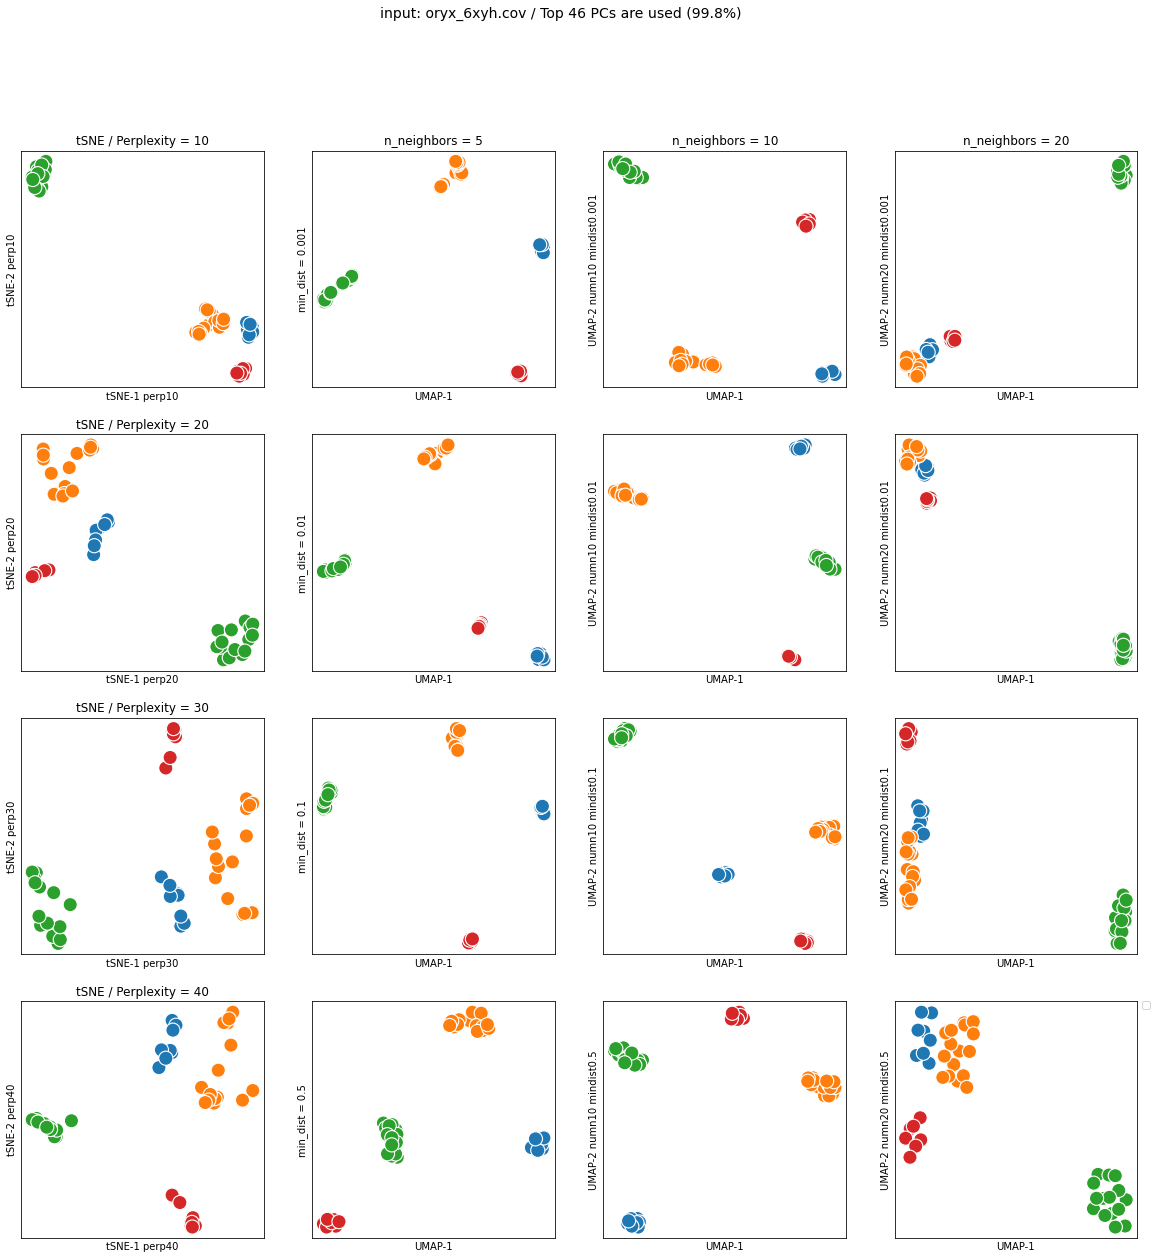

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


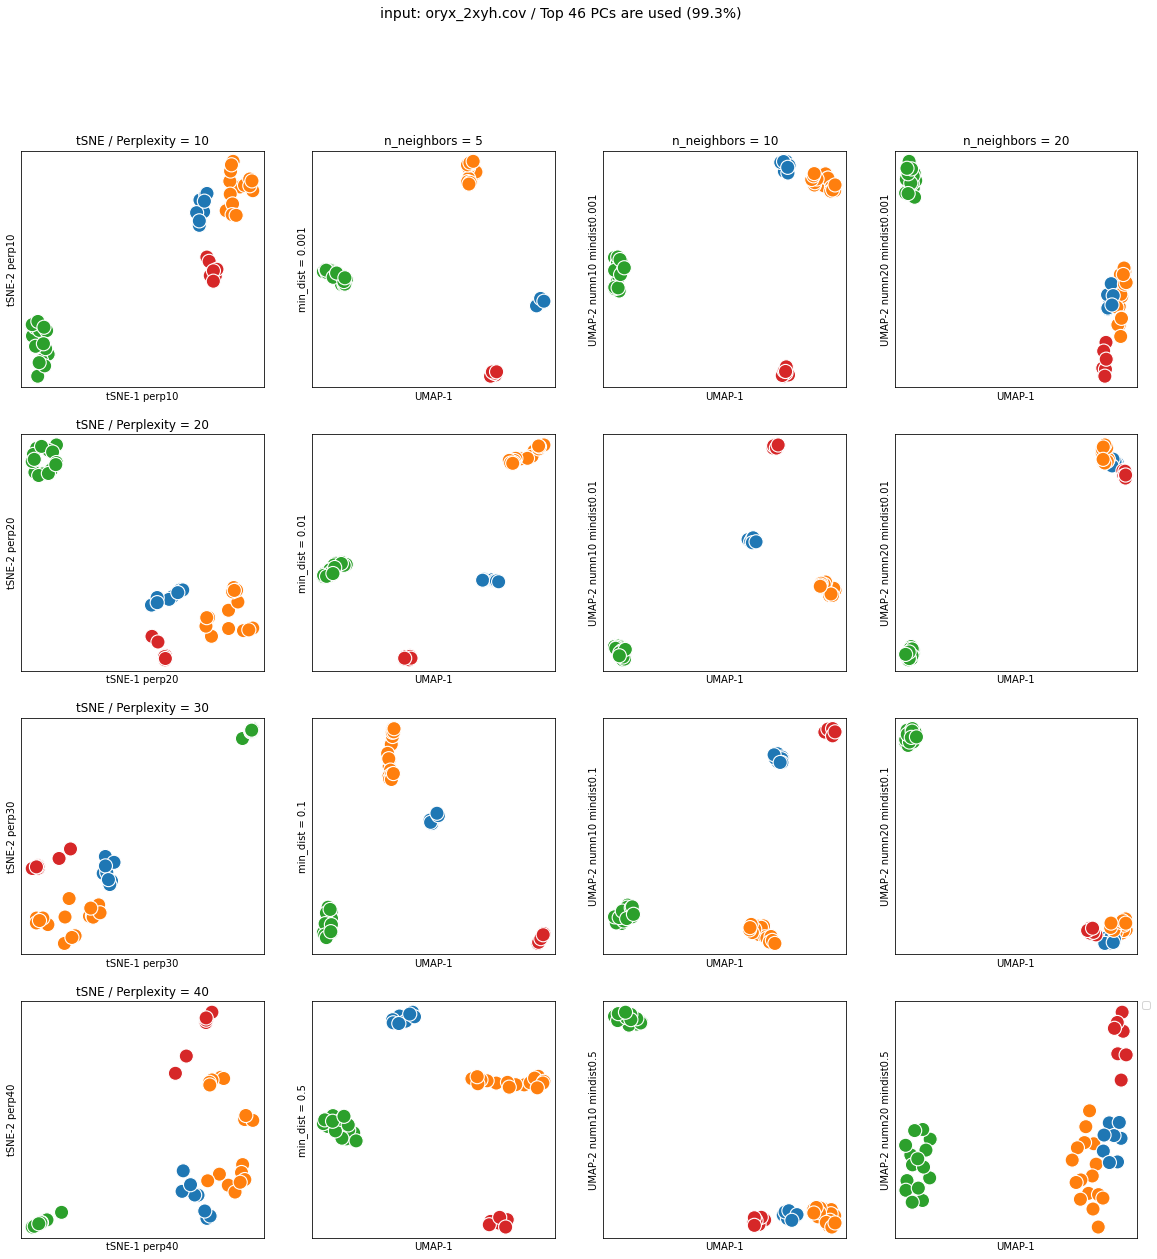

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


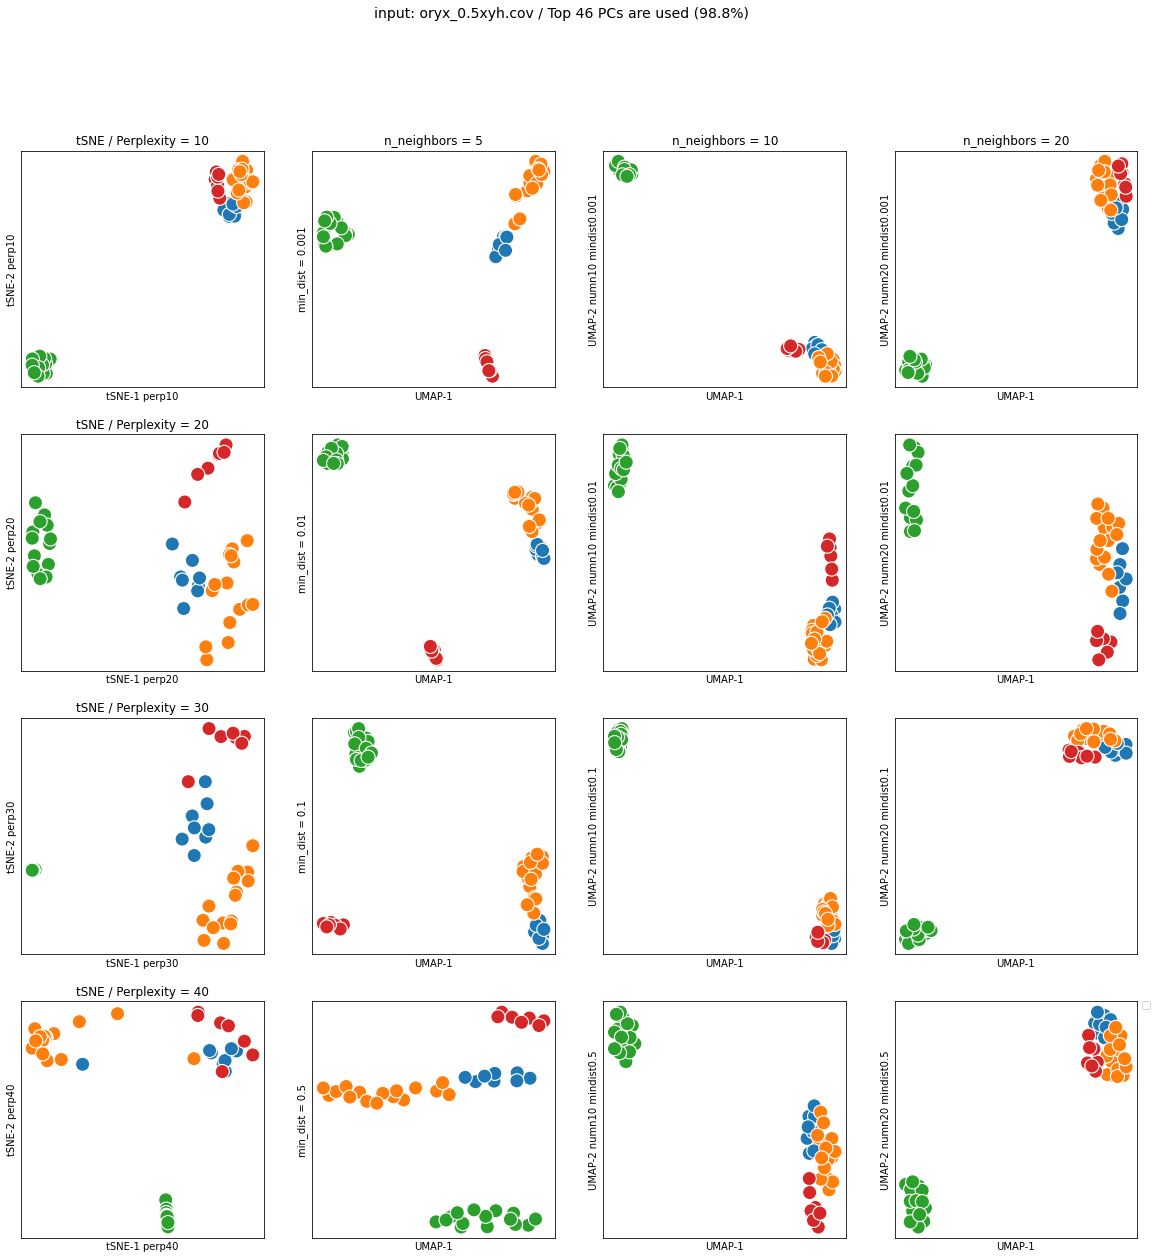

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.manifold import TSNE

def read_and_process_file(filename):
    cov_mat= pd.read_csv(filename, sep=' ', header=None)
    cov_mat_np=cov_mat.to_numpy()

    # Calculate eigen vectors and eigen values from the initial covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eig(cov_mat_np)

    # Sort eigenvalues/vectors
    idx = eigen_vals.argsort()[::-1]   
    eigenValues = eigen_vals[idx]
    eigenVectors = eigen_vecs[:,idx]
    scaled_eigenvectors = eigenVectors * eigenValues
    
    expl_pre = eigenValues / sum(eigenValues)
    expl = np.cumsum(expl_pre)

    expl_df = pd.DataFrame(expl_pre*100, columns=['explained_variance'])
    expl_df['cumulative_expl'] = expl * 100
    expl_df.set_index(np.arange(1, eigenVectors.shape[0] + 1), inplace=True)

    return scaled_eigenvectors, expl_df

def project_and_store(Data_Struct, pca_data_array, n_pc):
    # Project with t-SNE and UMAP
    perplexity_values = (10,20,30,40)
    for perp in perplexity_values:
        np.random.seed(111)
        proj_tsne = TSNE(n_components=2, perplexity=perp).fit_transform(pca_data_array[:,:n_pc])
        Data_Struct[f'tSNE-1 perp{perp}'] = proj_tsne[:,0]
        Data_Struct[f'tSNE-2 perp{perp}'] = proj_tsne[:,1]

    n_neighbors_nums = (5,10,20)
    mindists = (0.001,0.01,0.1,0.5)
    for nn in n_neighbors_nums:
        for mind in mindists:
            np.random.seed(111)
            proj_umap = umap.UMAP(n_components=2, n_neighbors=nn, min_dist=mind).fit_transform(pca_data_array[:,:n_pc])
            Data_Struct[f'UMAP-1 numn{nn} mindist{mind}'] = proj_umap[:,0]
            Data_Struct[f'UMAP-2 numn{nn} mindist{mind}'] = proj_umap[:,1]
    return Data_Struct

def create_plot(Data_Struct, filename, n_pc, expl_df):
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    fig.suptitle(f"input: {filename} / Top {n_pc} PCs are used ({round(expl_df['cumulative_expl'][n_pc-1], 1)}%)", fontsize=14)

    # t-SNE plots
    for i, perp in enumerate((10, 20, 30, 40)):
        sns.scatterplot(ax=axs[i, 0], data=Data_Struct, x=f'tSNE-1 perp{perp}', y=f'tSNE-2 perp{perp}', hue='Population', legend=False, s=200)
        axs[i, 0].set_title(f'tSNE / Perplexity = {perp}')
        axs[i, 0].set_xticks([])
        axs[i, 0].set_yticks([])

    # UMAP plots
    for j, nn in enumerate((5, 10, 20)):
        for i, mind in enumerate((0.001, 0.01, 0.1, 0.5)):
            sns.scatterplot(ax=axs[i, j+1], data=Data_Struct, x=f'UMAP-1 numn{nn} mindist{mind}', y=f'UMAP-2 numn{nn} mindist{mind}', hue='Population', legend=False, s=200)
            axs[i, j+1].set_xticks([])
            axs[i, j+1].set_yticks([])
            if i == 0:
                axs[i, j+1].set_title(f'n_neighbors = {nn}')
            axs[i, j+1].set_xlabel('UMAP-1')
            if j == 0:
                axs[i, j+1].set_ylabel(f'min_dist = {mind}')

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.savefig(f"{filename[:-4]}Top{n_pc}PCs.png", format='png', dpi=100, transparent=False, facecolor='white')
    plt.show()

# Main code execution
file_list = ('oryx_6xyh.cov', 'oryx_2xyh.cov', 'oryx_0.5xyh.cov')

# Load population names once outside the loop
population_names = pd.read_csv('oryx_pop_info_sorted_46_final.txt', sep='\t', header=0)

n_pc_values = [46]

for filename in file_list:
    pca_data_array, expl_df = read_and_process_file(filename)
    Data_Struct = {}
    Data_Struct['Population'] = population_names['Population'].to_numpy().squeeze()
    # replace 'YourColumnNameHere' with the actual column name that contains the population names
    
    for n_pc in n_pc_values:
        # Check if n_pc is not greater than the number of available components
        if n_pc <= len(expl_df):
            Data_Struct_temp = Data_Struct.copy()  # To ensure the original data structure isn't modified
            Data_Struct_temp = project_and_store(Data_Struct_temp, pca_data_array, n_pc)
            create_plot(Data_Struct_temp, filename, n_pc, expl_df)
        else:
            print(f"Cannot use {n_pc} components as only {len(expl_df)} components are available for {filename}")
